## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Load Training Images

In [1]:
import glob
import os
import sys

def get_img_path_in_folder(path_folder):
    full_path = path_folder + '/**/*.png'
    img_path_list = []

    for filename in glob.iglob(full_path, recursive=True):
        img_path_list.append(filename)

    return img_path_list

data_folder = './data'
vehicles_folder = data_folder + '/vehicles'
non_vehicles_folder = data_folder + '/non-vehicles'

vehicle_img_path = get_img_path_in_folder(vehicles_folder)
non_vehicle_img_path = get_img_path_in_folder(non_vehicles_folder)

print("Vehicles folder", vehicles_folder)
print("Non Vehicle Folder", non_vehicles_folder)

print("Vehicle Images", len(vehicle_img_path))
print("Non Vehicle Images", len(non_vehicle_img_path))

Vehicles folder ./data/vehicles
Non Vehicle Folder ./data/non-vehicles
Vehicle Images 8792
Non Vehicle Images 8968


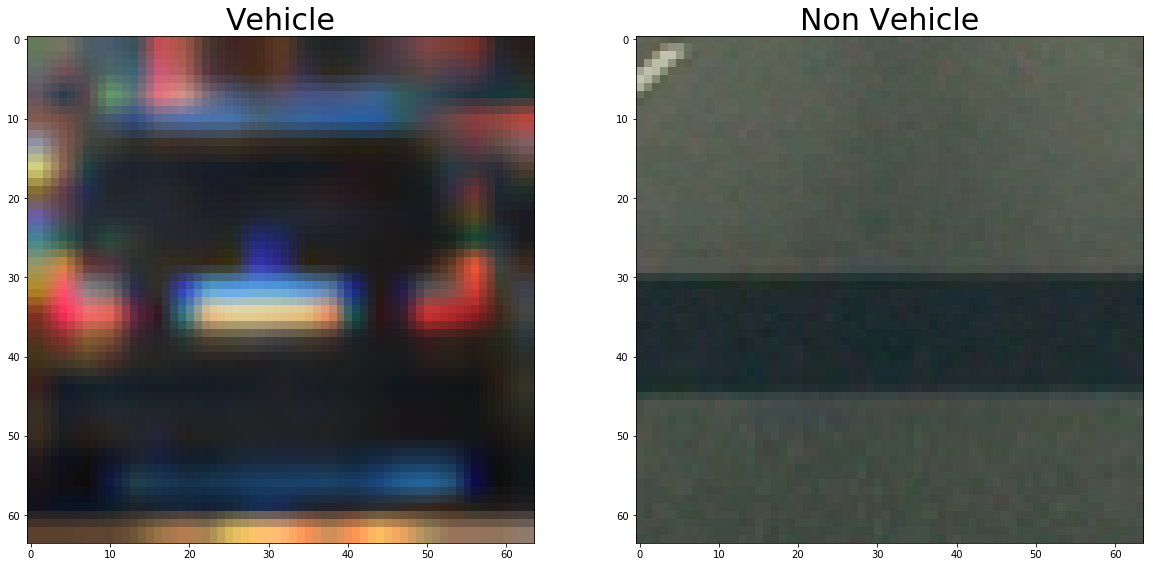

In [2]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def load_img(path):
    img_255_bgr = cv2.imread(path)
    img_255_rgb = cv2.cvtColor(img_255_bgr, cv2.COLOR_BGR2RGB)
    return img_255_rgb

def load_random_image(paths):
    len_path = len(paths)
    random_index = np.random.randint(0, len_path)
    return load_img(paths[random_index])


vehicle_img = load_random_image(vehicle_img_path)
no_vehicle_img = load_random_image(non_vehicle_img_path)
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(vehicle_img)
ax1.set_title('Vehicle', fontsize=30)
ax2.imshow(no_vehicle_img)
ax2.set_title('Non Vehicle', fontsize=30)


## Extract Features

In [3]:
from skimage.feature import hog
import numpy as np
import cv2

class Feature_Extractor():
    def __init__(self, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
        
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        pass
    
    def extract(self, img):
        
        color_space = self.color_space
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        hog_channel = self.hog_channel
        spatial_feat = self.spatial_feat
        hist_feat = self.hist_feat
        hog_feat = self.hog_feat
        
        #1) Define an empty list to receive features
        img_features = []
        
        #2) Apply color conversion if other than 'RGB'
        feature_image = self.transform_color(img, color_space)
        
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = self.bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
            
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = self.color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(self.get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
        
        
        #9) Return concatenated array of features
        return np.concatenate(img_features)
    
    def transform_color(self, img, color_space='RGB'):
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
        return feature_image
    
    # Define a function to compute binned color features  
    def bin_spatial(self, img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    
    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features

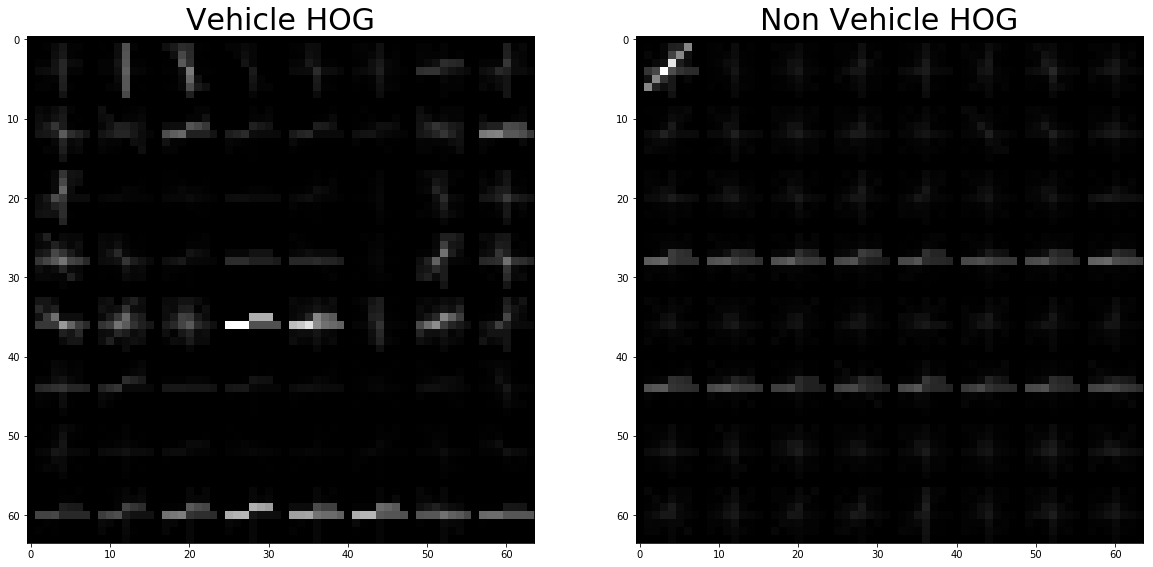

In [4]:
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"


extractor = Feature_Extractor(color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


car_hog_feature, car_hog_im = extractor.get_hog_features(vehicle_img[:,:,0], orient =12 , pix_per_cell = 8, cell_per_block = 2, vis=True, feature_vec=False)
non_car_hog_feature, non_car_hog_im = extractor.get_hog_features(no_vehicle_img[:,:,0], orient = 12, pix_per_cell = 8, cell_per_block = 2, vis=True, feature_vec=False)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(car_hog_im, cmap='gray')
ax1.set_title('Vehicle HOG', fontsize=30)
ax2.imshow(non_car_hog_im, cmap='gray')
ax2.set_title('Non Vehicle HOG', fontsize=30)

## Training

In [5]:
import numpy as np
from sklearn.utils import shuffle

def images_load_subset(images_path, subset):
    img_len = len(images_path)
    subset = np.clip(subset, 0, 1)
    new_len = img_len*subset
    new_len = int(round(new_len))
    return shuffle(images_path)[:new_len]


def extract_features(img_paths, extrator):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in img_paths:
        # Read in each one by one
        img_loaded = load_img(file)
        feature = extractor.extract(img_loaded)
        features.append(feature)
    return features

Vehicle Images: 8792 Available: 8792
Non Vehicle Images: 8968 Available: 8968
Extracting features. Please wait...
97.1 Seconds to extract HOG features...


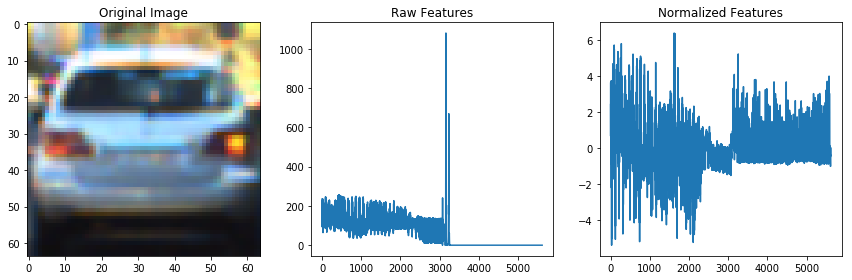

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.preprocessing import StandardScaler

%matplotlib inline

new_vehicle_images_path = images_load_subset(vehicle_img_path, 1)
new_non_vehicle_images_path = images_load_subset(non_vehicle_img_path, 1)

old_len = len(vehicle_img_path)
new_len = len(new_vehicle_images_path)
print("Vehicle Images: {0:2d} Available: {1:2d}".format(old_len, new_len))
old_len = len(non_vehicle_img_path)
new_len = len(new_non_vehicle_images_path)
print("Non Vehicle Images: {0:2d} Available: {1:2d}".format(old_len, new_len))

colorspace = 'LUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 0  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 64  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True # HOG features on or off


extractor = Feature_Extractor(color_space=colorspace, spatial_size = spatial_size,
                              hist_bins = hist_bins, orient=orient, 
                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel = hog_channel,
                              spatial_feat = True, hist_feat = True, hog_feat = True)

t=time.time()

print('Extracting features. Please wait...')
len_car_images = len(new_vehicle_images_path)
car_features = extract_features(new_vehicle_images_path, extractor)
notcar_features = extract_features(new_non_vehicle_images_path, extractor)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len_car_images)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(load_img(new_vehicle_images_path[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## Build a Classifier

In [8]:
from sklearn.model_selection import train_test_split

y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

Test Accuracy of SVC =  0.983671171171


In [9]:
class SimpleVehicleClassifier():
    def __init__(self, extractor, classifier, scaler):
        self.extractor = extractor
        self.classifier = classifier
        self.scaler = scaler
    def is_vehicle(self, img):
        features = self.extractor.extract(img)
        test_features = self.scaler.transform(np.array(features).reshape(1, -1))
        prediction = self.classifier.predict(test_features)
        if prediction == 1:
            return True
        else:
            return False

## Vehicle Classifier

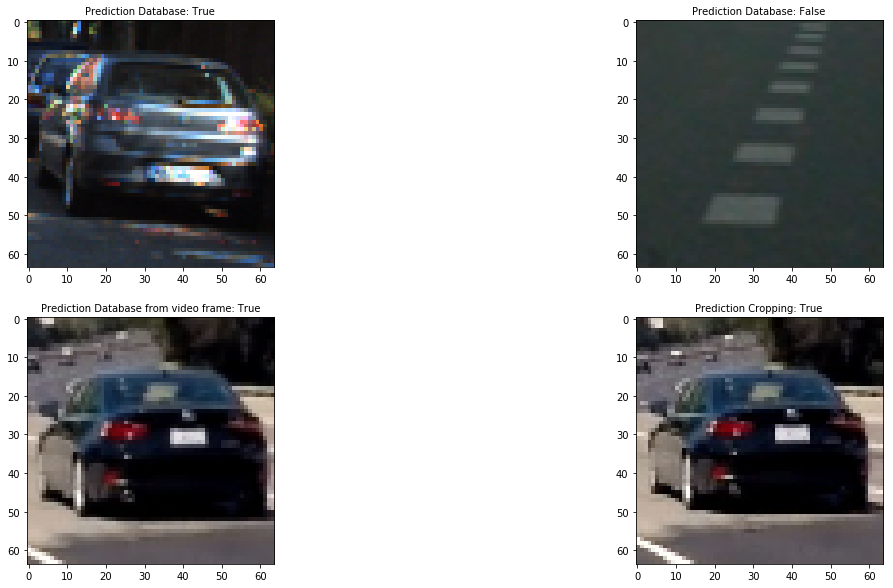

In [12]:
car_ind = np.random.randint(0, len(vehicle_img_path))
non_car_ind = np.random.randint(0, len(non_vehicle_img_path))

vehicle_img = load_img(vehicle_img_path[car_ind])
non_vehicle_img = load_img(non_vehicle_img_path[non_car_ind])

simpleClassifier = SimpleVehicleClassifier(extractor, svc, X_scaler)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(vehicle_img)
is_vehicle = simpleClassifier.is_vehicle(vehicle_img)
title = 'Prediction Database: ' + str(is_vehicle)
ax1.set_title(title, fontsize=10)

ax2.imshow(non_vehicle_img)
is_vehicle = simpleClassifier.is_vehicle(non_vehicle_img)
title = 'Prediction Database: ' + str(is_vehicle)
ax2.set_title(title, fontsize=10)

vehicle_in_window = load_img('./test_images/vehicle_2.png')
ax3.imshow(vehicle_in_window)
is_vehicle = simpleClassifier.is_vehicle(vehicle_in_window)
title = 'Prediction Database from video frame: ' + str(is_vehicle)
ax3.set_title(title, fontsize=10)

crop_image = load_img('./test_images/test4.jpg')
window = ((807, 380),(950, 525))
crop_image = cv2.resize(crop_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

ax4.imshow(crop_image)
is_vehicle = simpleClassifier.is_vehicle(crop_image)
title = 'Prediction Cropping: ' + str(is_vehicle)
ax4.set_title(title, fontsize=10)

## Window Creator

In [56]:
import numpy as np
import cv2

def round_int(num):
    return int(round(num))

class Window_Creator:
    
    def __init__(self, window_size, overlap):
        self.window_size = window_size
        self.overlap = overlap
    
    def get_complex_windows(self, img):
        
        height = img.shape[0]
        y_start = 0.5*height
        y_start = int(round(y_start))
        new_y_start_stop = [y_start, None]
        
        windows_full = []
        windows = []
        
        #windows_full, windows = self.get_window_shortcut(img, 50, 0.0, int(round(0.5*height)), int(round(0.7*height)), windows_full, windows)
        #windows_full, windows = self.get_window_shortcut(img, 100, 0.0, int(round(0.5*height)), None, windows_full, windows)
        windows_full, windows = self.get_window_shortcut(img, 64, 0.8, round_int(0.5*height), round_int(0.7*height), windows_full, windows)
        windows_full, windows = self.get_window_shortcut(img, 96, 0.8, round_int(0.5*height), round_int(0.7*height), windows_full, windows) 
        windows_full, windows = self.get_window_shortcut(img, 128, 0.8, round_int(0.5*height), round_int(0.85*height), windows_full, windows)
        #windows_full, windows = self.get_window_shortcut(img, 200, 0.7, int(round(0.5*height)), None, windows_full, windows)
        #windows_full, windows = self.get_window_shortcut(img, 250, 0.8, int(round(0.5*height)), None, windows_full, windows)

        return windows_full, windows
        
    def concatenate(self, main_list, new_elements):
        for element in new_elements:
            main_list.append(element)
            
        return main_list
    
    def get_window_shortcut(self, img, size, overlap, y_start, y_stop, windows_full, windows):
        aux = self.slide_window(img, xy_window = (size, size), xy_overlap = (overlap, overlap), y_start_stop = [y_start, y_stop])
        windows.append(aux)
        windows_full = self.concatenate(windows_full, aux)
        return windows_full, windows
    
    def get_windows(self, img):
        windows = self.slide_window(img, xy_window = self.window_size, xy_overlap = self.overlap)
        return windows
    def slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
     
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list
    
    def draw_windows(self, img):
        windows_full, windows = self.get_complex_windows(img)
        imcopy = np.copy(img)
        thick = 2
        for windows_part in windows:
            r = np.random.randint(0, 255)
            g = np.random.randint(0, 255)
            b = np.random.randint(0, 255)
            imcopy = self.draw_boxes(imcopy, windows_part, color = (r,g,b, 0.5), thick = thick)
            thick +=1
        
        return imcopy
        
    
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=2):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            
            if (color == 'RANDOM'):
                r = np.random.randint(0, 255)
                g = np.random.randint(0, 255)
                b = np.random.randint(0, 255)
                c = (r,g,b)
            else:
                c = color
            cv2.rectangle(imcopy, bbox[0], bbox[1], c, thick)
        # Return the image copy with boxes drawn
        return imcopy


Total Windows:  1185


IndexError: list index out of range

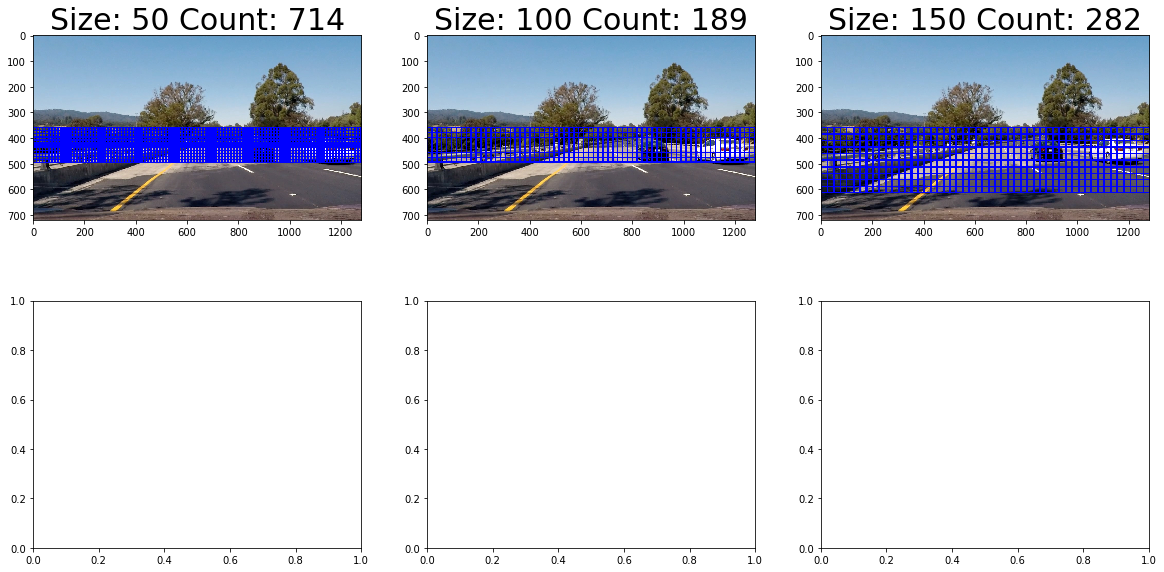

In [57]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

test_img_folder = './test_images/test4.jpg'
test_image = load_img(test_img_folder)

window_creator = Window_Creator(window_size = (128, 128), overlap = (0.1, 0.1))
image_with_window = window_creator.draw_windows(test_image)

windows_full, windows = window_creator.get_complex_windows(test_image)
print("Total Windows: ", len(windows_full))

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
ax1.imshow(window_creator.draw_boxes(test_image, windows[0], color = (0,0,255), thick = 4))
num_windows = len(windows[0])
title = "Size: " + str(50) + " Count: " + str(num_windows) 
ax1.set_title(title, fontsize=30)
ax2.imshow(window_creator.draw_boxes(test_image, windows[1], color = (0,0,255), thick = 4))
num_windows = len(windows[1])
title = "Size: " + str(100) + " Count: " + str(num_windows) 
ax2.set_title(title, fontsize=30)
ax3.imshow(window_creator.draw_boxes(test_image, windows[2], color = (0,0,255), thick = 4))
num_windows = len(windows[2])
title = "Size: " + str(150) + " Count: " + str(num_windows) 
ax3.set_title(title, fontsize=30)
ax4.imshow(window_creator.draw_boxes(test_image, windows[3], color = (0,0,255), thick = 4))
num_windows = len(windows[3])
title = "Size: " + str(200) + " Count: " + str(num_windows) 
ax4.set_title(title, fontsize=30)
ax5.imshow(window_creator.draw_boxes(test_image, windows[4], color = (0,0,255), thick = 4))
num_windows = len(windows[4])
title = "Size: " + str(250) + " Count: " + str(num_windows) 
ax5.set_title(title, fontsize=30)
ax6.imshow(image_with_window)
title = 'Result'
ax6.set_title(title, fontsize=30)

## Heatmap

In [58]:
class FixedListQueue():
    def __init__(self, max_size = 3):
        self.count = 0
        self.max_size = max_size
        self.queue = []
        self.full_list = []
        pass
    def enqueue(self, list_to_enqueue):
        if (self.count < self.max_size):
            self.queue.append(list_to_enqueue)
            self.count += 1
        else:
            lastIndex = self.count - 1
            for i in range(0, lastIndex):
                self.queue[i] = self.queue[i+1]

            self.queue[lastIndex] = list_to_enqueue
            
        self.full_list = []
        
        for l in self.queue:
            for element in l:
                self.full_list.append(element)
                
        #print("QueueSize", self.count)
                
print('---------------------------------')
queue = FixedListQueue(max_size = 3)
boxes = []
boxes.append(((1, 2), (3, 4)))
boxes.append(((5, 6), (7, 8)))
print("Enqueing", boxes)
queue.enqueue(boxes)
print("Queue:", queue.queue)
print("Size:", queue.count)
print("Full List", queue.full_list)
print('---------------------------------')
boxes = []
boxes.append(((10, 20), (30, 40)))
boxes.append(((50, 60), (70, 80)))
print("Enqueing", boxes)
queue.enqueue(boxes)
print("Queue:", queue.queue)
print("Size:", queue.count)
print("Full List", queue.full_list)
print('---------------------------------')
boxes = []
boxes.append(((100, 200), (300, 400)))
boxes.append(((500, 600), (700, 800)))
print("Enqueing", boxes)
queue.enqueue(boxes)
print("Queue:", queue.queue)
print("Size:", queue.count)
print("Full List", queue.full_list)
print('---------------------------------')
boxes = []
boxes.append(((1000, 2000), (3000, 4000)))
boxes.append(((5000, 6000), (7000, 8000)))
print("Enqueing", boxes)
queue.enqueue(boxes)
print("Queue:", queue.queue)
print("Size:", queue.count)
print("Full List", queue.full_list)
print('---------------------------------')


---------------------------------
Enqueing [((1, 2), (3, 4)), ((5, 6), (7, 8))]
Queue: [[((1, 2), (3, 4)), ((5, 6), (7, 8))]]
Size: 1
Full List [((1, 2), (3, 4)), ((5, 6), (7, 8))]
---------------------------------
Enqueing [((10, 20), (30, 40)), ((50, 60), (70, 80))]
Queue: [[((1, 2), (3, 4)), ((5, 6), (7, 8))], [((10, 20), (30, 40)), ((50, 60), (70, 80))]]
Size: 2
Full List [((1, 2), (3, 4)), ((5, 6), (7, 8)), ((10, 20), (30, 40)), ((50, 60), (70, 80))]
---------------------------------
Enqueing [((100, 200), (300, 400)), ((500, 600), (700, 800))]
Queue: [[((1, 2), (3, 4)), ((5, 6), (7, 8))], [((10, 20), (30, 40)), ((50, 60), (70, 80))], [((100, 200), (300, 400)), ((500, 600), (700, 800))]]
Size: 3
Full List [((1, 2), (3, 4)), ((5, 6), (7, 8)), ((10, 20), (30, 40)), ((50, 60), (70, 80)), ((100, 200), (300, 400)), ((500, 600), (700, 800))]
---------------------------------
Enqueing [((1000, 2000), (3000, 4000)), ((5000, 6000), (7000, 8000))]
Queue: [[((10, 20), (30, 40)), ((50, 60), (

In [59]:
from scipy.ndimage.measurements import label


class HeatMap():
    def __init__(self, size):
        self.size = size
        self.threshold = 1
        self.max_feed = 1
        self.heatmap = np.zeros(self.size).astype(np.float)       
        self.queue = FixedListQueue(self.max_feed)
        pass    

    def feed(self, boxes):
        self.queue.enqueue(boxes)
        cached_boxes = self.queue.full_list
        
        self.heatmap = np.zeros(self.size).astype(np.float)
        self.heatmap = self.add_heat(self.heatmap, cached_boxes)
        self.heatmap = self.apply_threshold(self.heatmap, self.threshold)
        self.heatmap_img = self.get_heatmap_img(self.heatmap)
        self.labels = heatmap.get_labels(self.heatmap_img)
        self.boxes = heatmap.get_boxes_from_labels(self.labels)

            
    def add_heat(self, heatmap, boxes):
        # Iterate through list of bboxes
        for box in boxes:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        return heatmap
            
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        return heatmap
    def get_heatmap_img(self, heatmap):
        return np.clip(heatmap, 0, 255)
    def get_labels(self, heatmap_img):
        return label(heatmap_img)
    def get_boxes_from_labels(self, labels):
        boxes = []
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            boxes.append(bbox)
        # Return the image
        return boxes


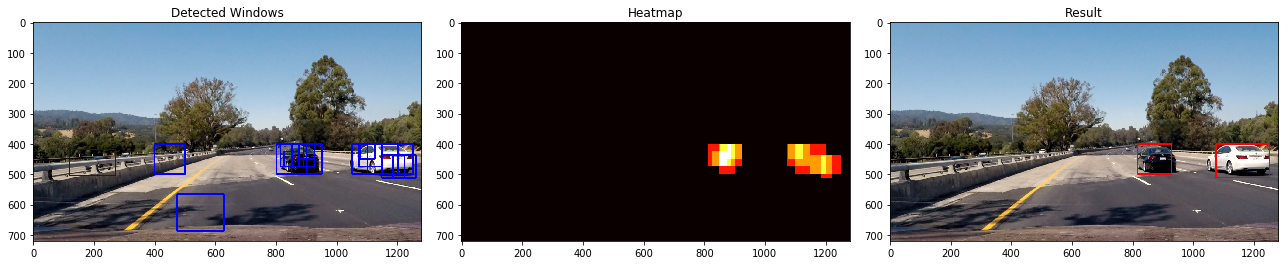

In [60]:
heatmap = HeatMap((720, 1280))

boxes = []
boxes.append(((120, 418), (271, 504)))
boxes.append(((473, 565), (628, 686)))
boxes.append(((800, 400), (900, 500))) 
boxes.append(((850, 400), (950, 500))) 
boxes.append(((1050, 400), (1150, 500))) 
boxes.append(((1100, 400), (1200, 500)))
boxes.append(((1150, 400), (1250, 500))) 
boxes.append(((875, 400), (925, 450))) 
boxes.append(((1075, 400), (1125, 450))) 
boxes.append(((825, 425), (875, 475))) 
boxes.append(((814, 400), (889, 475))) 
boxes.append(((851, 400), (926, 475))) 
boxes.append(((1073, 400), (1148, 475))) 
boxes.append(((1147, 437), (1222, 512)))
boxes.append(((1184, 437), (1259, 512)))
boxes.append(((400, 400), (500, 500)))

heatmap.queue.max_size = 3
heatmap.feed(boxes)

windows_positive_image = window_creator.draw_boxes(test_image, boxes, thick = 4)
windows_with_vehicles = window_creator.draw_boxes(test_image, heatmap.boxes, color = (255, 0,0), thick = 4)

fig = plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(windows_positive_image)
plt.title('Detected Windows')
plt.subplot(132)
plt.imshow(heatmap.heatmap_img, cmap='hot')
plt.title('Heatmap')
plt.subplot(133)
plt.imshow(windows_with_vehicles)

plt.title('Result')
fig.tight_layout()

## Vehicle Detector

In [61]:
class VehicleDetector():
    def __init__(self, simple_detector, window_creator, heatmap):
        self.simple_detector = simple_detector
        self.window_creator = window_creator
        self.heatmap = heatmap
        
        self.windows_with_vehicle = []
    def configure(self, threshold_frame, threshold_heat):
        self.windows_with_vehicle = []
        
        self.heatmap.max_feed = threshold_frame
        self.heatmap.threshold = threshold_heat
        self.heatmap.boxes = []
        self.heatmap.queue.count = 0
        self.heatmap.queue.max_size = threshold_frame
        self.heatmap.queue.queue = []
        self.heatmap.queue.full_list = []             
        
    def detect(self, img):
        windows_full, windows = self.get_windows(img)
        self.windows_with_vehicle = []
        count = 0
        for window in windows_full:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            #print(np.amax(test_img))
            #plt.figure(count)
            #plt.imshow(test_img)
            count = count + 1
            is_vehicle = self.simple_detector.is_vehicle(test_img)
            if (is_vehicle == True):
                #print("Found!")
                self.windows_with_vehicle.append(window)
        #print(count)
        self.heatmap.feed(self.windows_with_vehicle)
        
        vehicles_detected_from_heatmap = self.heatmap.boxes
        self.result = self.window_creator.draw_boxes(img, vehicles_detected_from_heatmap, color=(0, 255, 0), thick=4)
        return self.result
        #heatmap_img = self.heatmap.heatmap_img
        #heat_max = np.amax(heatmap_img)
        #print(heatmap_img)
        #print(heat_max)
        #heatmap_img = (heatmap_img/heat_max)*255
        #heatmap_rgb = np.dstack((np.zeros_like(heatmap_img), np.zeros_like(heatmap_img), heatmap_img))

        #return heatmap_rgb
        #full_list = self.heatmap.queue.full_list
        #heatmap_vehicles = self.heatmap.boxes
        #aux = self.window_creator.draw_boxes(img*255, windows_with_vehicle, color=(0, 0, 255), thick=1)
        #aux = self.window_creator.draw_boxes(aux, full_list, color=(0, 255, 0), thick=1)

        #return self.window_creator.draw_boxes(aux, heatmap_vehicles, color=(255, 0, 0), thick=6)

    
    def get_windows(self, img):
        windows = []
        windows = self.window_creator.get_complex_windows(img)
        return windows

                
        

Max Votes: 6.0


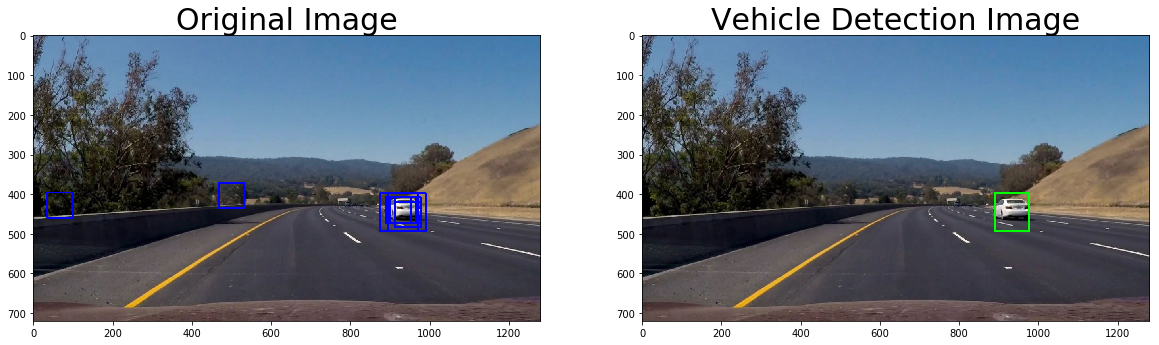

In [85]:
test_image_path = './test_images/test8.jpg'
test_image = load_img(test_image_path)

vehicle_detector = VehicleDetector(simpleClassifier, window_creator, heatmap)
vehicle_detector.configure(threshold_frame = 1, threshold_heat =1)

result = vehicle_detector.detect(test_image)

heat_max = np.amax(vehicle_detector.heatmap.heatmap_img)
print("Max Votes:", heat_max)

all_positives = window_creator.draw_boxes(test_image, vehicle_detector.windows_with_vehicle, color=(0, 0, 255), thick=4)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(all_positives)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result)
ax2.set_title('Vehicle Detection Image', fontsize=30)

## Video Pipeline

Detecting, please wait...
Min: 2.000000 Max: 18.000000 Mean: 6.386154
Min: 2.000000 Max: 18.000000 Mean: 6.555941
Min: 2.000000 Max: 19.000000 Mean: 5.872607
Min: 2.000000 Max: 18.000000 Mean: 6.257160
Min: 2.000000 Max: 18.000000 Mean: 5.567806
Min: 2.000000 Max: 14.000000 Mean: 5.386654


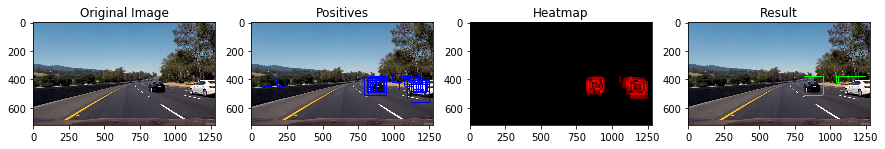

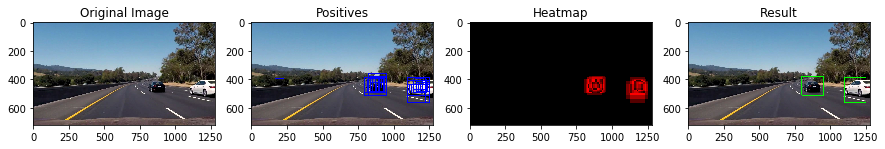

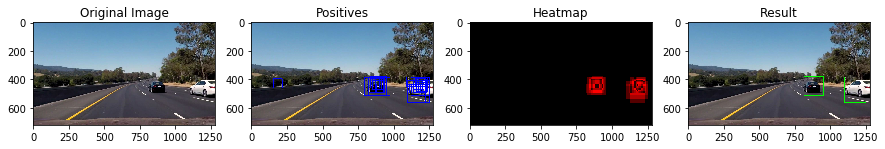

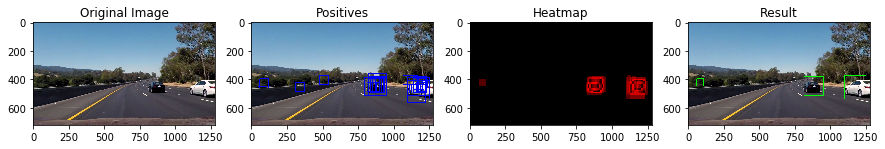

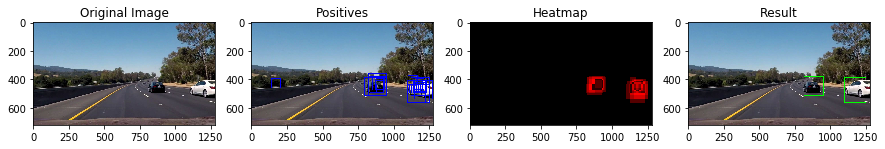

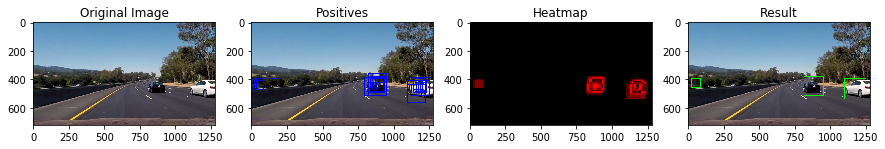

In [86]:
def heatmap_to_drawable(heatmap_img):
    nonzero = heatmap_img[np.nonzero(heatmap_img)]
    min_value = np.amin(nonzero)
    max_value = np.amax(nonzero)
    mean = np.mean(nonzero)
    print("Min: {0:2f} Max: {1:2f} Mean: {2:2f}".format(min_value, max_value, mean))
    if (heat_max > 0):
        heatmap_img = (heatmap_img/heat_max)*255.0
    heatmap_rgb = np.dstack((heatmap_img, np.zeros_like(heatmap_img), np.zeros_like(heatmap_img)))
    return heatmap_rgb

def draw(vehicle_detector, img):
    #print(vehicle_detector.heatmap.queue.full_list)
    all_positives = window_creator.draw_boxes(img, vehicle_detector.windows_with_vehicle, color=(0, 0, 255), thick=4)
    #plt.imshow(heatmap.heatmap_img, cmap='hot')
    heatmap_img = heatmap_to_drawable(vehicle_detector.heatmap.heatmap_img)
    result = vehicle_detector.result
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=12)
    ax2.imshow(all_positives)
    ax2.set_title('Positives', fontsize=12)
    ax3.imshow(heatmap_img*255, cmap = 'hot')
    ax3.set_title('Heatmap', fontsize=12)
    ax4.imshow(result)
    ax4.set_title('Result', fontsize=12)

burst = []
burst.append(load_img('./test_images/burst/burst_01.jpg'))
burst.append(load_img('./test_images/burst/burst_02.jpg'))
burst.append(load_img('./test_images/burst/burst_03.jpg'))
burst.append(load_img('./test_images/burst/burst_04.jpg'))
burst.append(load_img('./test_images/burst/burst_05.jpg'))
burst.append(load_img('./test_images/burst/burst_06.jpg'))

vehicle_detector.configure(threshold_frame = 1, threshold_heat = 1)
print("Detecting, please wait...")
for im in burst:
    vehicle_detector.detect(im)
    draw(vehicle_detector, im)

In [92]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vehicle_detector = VehicleDetector(simpleClassifier, window_creator, heatmap)
vehicle_detector.configure(threshold_frame = 1, threshold_heat = 2)

video_output = 'out_project_video.mp4'
#clip1 = VideoFileClip("project_video_shortest.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(38, 38.1)
#clip1 = VideoFileClip("project_video.mp4").subclip(38, 48.1).set_fps(1)
#clip1 = VideoFileClip("project_video.mp4").set_fps(5)
clip1 = VideoFileClip("project_video.mp4")



#clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")




#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip = clip1.fl_image(vehicle_detector.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [47:24<00:02,  2.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

Wall time: 47min 24s
